In [356]:
# TODO

# OK Make CSV separations for each edition
# NAH Look at any EXTRA CLEANING that can be done (eg. if definition is mostly noise, for_later)

# OK generate basic info CSV & give to Ava
# OK send to Ava, mention 40->20
# OK mention where i'm putting the PNGs

# CURRENT Generate complex header & refs data for each edition, two-by-two and save as CSV

# longest word in each edition & definition (a bit manual) 

# FOR 5 AVA TOPICS:
# generate list of how many words with references to it in each edition
# list of words that have that reference in their definition

# For TOPIC VISUALISATION:
# OK change colour to plain
# OK remove common outliers ("see next article"), etc
# OK remove "see"
# generate for all 8 editions
# associate to discoveries & evolutions of specific topics, ask data holder!
# click the word to see modern definition, contextual real-world events for why this topic is popular then

# For TOPIC PROPORTIONAL CHANGE:
# re-clean refs using the complete refs cleaning ft, and remove too-long refs
# a (1) -- (2) -- (2) -- (3) mini-graph for the most popular topics?
# check for shortest and longest ref?
# anatomy count across all editions, normalise by the count of total across editions (?)
# look at top 5 positions across time?
# "less important", "mostly mentioned in edition x"
# count overall all editions: most common topics, and visualise how they evolved
# bar chart progress rather than line chart
# make distances between values reflect year of publication

# FOR GROUPING TOPICS:
# group top x topics into bigger topics eg. science, arts etc, and visualise horizontal bars of proportions in each edition

# WEBSITE:
# add to slider images of books to represent quantity of knowledge (each book is 100'000 words in that edition)
# publishing the final code in a clean github repository, add profiles of us on website
# images change as you change editions, or morphing of current/old images

# PRESENTATION:
# slides responding to benjamin's questions in email

# SUBMISSION:
# guided video
# report

# OTHER:
# longest word, others in https://github.com/vaidap/library/issues/9?
# how definitions change across time for select words (longest def/shortest def)

# #######################
# Ask Sarah about how editions are separated/duplicates.
# then, make this run for all editions in parts & save into CSVs
# Ask Sarah if we can see the real encyclopaedia?
# Ask Alexander about proportional word frequency, how to calc: prop of all frequency?

# generate data always on cleaned up versions of text

# look through CW2 cleanup & code: what could be ported over
# for_later notes eg. \n clean

# DONE
# words/characters/volumes per edition
# run two_data & port re-format & visualisation from CW2
# save data in csv

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import csv
%matplotlib inline

In [2]:
# reading in index file

inventory = pd.read_csv("encyclopaediaBritannica-inventory.csv", header=None)
inventory.columns = ['file','volume']
# print(inventory)
print("\nNumber of text files: " + str(len(inventory)))


Number of text files: 195


## Selecting volumes for each edition

In [3]:
# ignore supplements & index volumes

first_ed = inventory[:3]
first_ed_reprint = inventory[3:7]
second_ed = inventory[6:16]
third_ed = inventory[16:34]
third_ed_reprint = inventory[34:52]
fourth_ed = inventory[56:96]
fifth_ed = inventory[96:116]
sixth_ed = inventory[116:136]
seventh_ed = inventory[152:172]
eighth_ed = inventory[173:194]

In [5]:
eighth_ed = inventory[173:194]
list(eighth_ed['volume']) # list() to print whole text

['Encyclopaedia Britannica - Eighth edition, Volume 1, Dissertations - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 2, A-Anatomy - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 3, Anatomy-Astronomy - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 4, Astronomy-BOM - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 5, Bombay-BUR - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 6, Burning glasses-Climate - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 7, CLI-DIA - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 8, Diamond-Entail - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 9, Entomology-FRA - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 10, France-GRA - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 11, GRA-HUM - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 12, Hume-JOM - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 13, Jona

In [4]:
# doesn't include reprints 
all_editions = [first_ed, second_ed, third_ed, fourth_ed, fifth_ed, sixth_ed, seventh_ed, eighth_ed]

In [6]:
# for testing
two_editions = [first_ed, second_ed]

## Basic statistics

In [7]:
# Reading in text files and generate volume, word and length counts

def basic_data(editions):
    
    data = []
    
    for ed in editions: 
        length = 0
        words = 0
        volumes = 0

        for index, row in ed.iterrows():
            print("Reading: " + row['file'])

            f = open('text/' + row['file'], 'r', encoding="utf8")
            content = f.read()
            content = clean_up(content)
            length += len(content)
            volumes += 1

            words += len(content.split())

            f.close()
            
        data.append([volumes, length, words])
        data_df=pd.DataFrame(data,columns=['volumes', 'length_chars','length_words'])
    return data_df

In [231]:
basic_df = basic_data(all_editions)
basic_df

Reading: 144133901.txt
Reading: 144133902.txt
Reading: 144133903.txt
Reading: 144850370.txt
Reading: 144850373.txt
Reading: 144850374.txt
Reading: 144850375.txt
Reading: 144850376.txt
Reading: 144850377.txt
Reading: 144850378.txt
Reading: 144850379.txt
Reading: 190273289.txt
Reading: 190273290.txt
Reading: 190273291.txt
Reading: 149977338.txt
Reading: 149977873.txt
Reading: 149978642.txt
Reading: 149979156.txt
Reading: 149979622.txt
Reading: 149981189.txt
Reading: 149981670.txt
Reading: 149982181.txt
Reading: 149982692.txt
Reading: 149983206.txt
Reading: 190273372.txt
Reading: 191253798.txt
Reading: 192200061.txt
Reading: 191253799.txt
Reading: 191319917.txt
Reading: 191253800.txt
Reading: 191253817.txt
Reading: 191253818.txt
Reading: 191253819.txt
Reading: 192545783.txt
Reading: 192545784.txt
Reading: 191809865.txt
Reading: 191809866.txt
Reading: 191253825.txt
Reading: 191253826.txt
Reading: 191320556.txt
Reading: 191320557.txt
Reading: 192547776.txt
Reading: 192547777.txt
Reading: 19

,volumes,length_chars,length_words
0,3,14191040,2567260
1,10,56733498,10172846
2,18,96884019,17414509
3,40,103931985,18672098
4,20,103686840,18617826
5,20,103513075,18597305
6,20,119701529,21056156
7,21,131624089,22878318


In [232]:
basic_df.to_csv('csv/basic_data.csv')

In [234]:
basic_reimport = pd.read_csv('csv/basic_data.csv')
print(basic_reimport) # edition 4 is actually 20 volumes because text files separate it into part 1 & 2

   Unnamed: 0  volumes  length_chars  length_words
0           0        3      14191040       2567260
1           1       10      56733498      10172846
2           2       18      96884019      17414509
3           3       40     103931985      18672098
4           4       20     103686840      18617826
5           5       20     103513075      18597305
6           6       20     119701529      21056156
7           7       21     131624089      22878318


## Most referenced topics

### Helper functions

#### For cleanup

In [8]:
def replace_by(s, a, b):
    """ perform a regex replacement, prints number of occurrences found and returns a string.
    s: string to make changes in
    a: string to remove 
    b: string to add
    returns: a string"""
    
    # print("Replacing \"" + a + "\" by \"" + b + "\", found " + str(len(re.findall(a, s))) + "...")
    new = re.sub(a, b, s)
    
    return new

In [9]:
# Using regex cleanup ideas from: https://sites.temple.edu/tudsc/2014/08/12/text-scrubbing-hacks-cleaning-your-ocred-text/

# Further resources: https://programminghistorian.org/en/lessons/cleaning-ocrd-text-with-regular-expressions
# https://datascience.stackexchange.com/questions/20536/how-to-improve-ocr-scanning-results

def clean_up(s):
    """ Does a minimal cleanup of a string of text
    returns: a string
    """
    # print("Initial length: " + str(len(s)))
    s2 = replace_by(s, 'tbe', 'the')
    s3 = replace_by(s2, 'tiie', 'the')
    s4 = replace_by(s3, 'liis', 'his')
    s5 = replace_by(s4, 'bis', 'his')
    s6 = replace_by(s5, '■', '')
    s7 = replace_by(s6, 'ib','in') # was noticed by Ava in .txt files
    s8 = replace_by(s7, '¬','')
    s9 = replace_by(s8, '.(\.\.+)', '') # multiple periods; what about ellipsis though?
    # print("Clean up done!")
    return s9 # CAREFUL to always pass the right one to next, and return

In [10]:
# This uses the list of header/definition/refs dataframes for each edition
# Check that this doesn't just do a reference replace, actually changes editions that are passed to it

def clean_up_definitions(editions):
    editions_cleaned = []
    for ed in editions:
        # realistically, a definition can't be shorter than 5 letters, even if it is simply a redirection of the form of "See x"
        ed = ed.loc[ed['def_length'] > 5]
        # remove headers with two letters as they are probably mostly noise
        ed = ed.loc[ed['header_length'] > 2]
        # remove headers longer than 40 characters, as these are likely to be noise
        ed = ed.loc[ed['header_length'] < 40]
        
        # We might also want to drop header duplicates, as each entry is only defined once
        # A good portion of these duplicates are probably noise (such as annotations in roman numerals)
        # We're not selecting the correct definition out of the duplicates here, just dropping them for the sake of simplicity
        ed.drop_duplicates(subset ="headers", keep = False, inplace = True)
        
        editions_cleaned.append(ed)
        
    return editions_cleaned

#### For extracting words and their definitions, and references ("See x")

In [11]:
# Uses RegEx to identify the definition of a word as being the content between the uppercase word and the next uppercase word

def find_definition(word, volume):
    start = re.search(word, volume).start()
    start_next = re.search(word, volume).end()
    
    second_word = re.search("[A-Z][A-Z]+", volume[start_next:])
    
    if second_word: # checking that second capitalised word exists (prevents NoneType exception)
        end = re.search("[A-Z][A-Z]+", volume[start_next:]).start()
        return volume[start_next+2:start_next+end] # +2 to ignore comma and space before a definition
    else:
        return ""

In [12]:
# Extracts entries (headers), their definitions, their respective lengths, and all references ("See x") from an edition

def extract_info(edition):
    
    headers = []
    definitions = []
    refs = [] # for counting up all instances of "See x" in volumes  
    
    for index, row in edition.iterrows():
        current_headers = []
        
        print("Reading: " + row['file'])
        f = open('text/' + row['file'], 'r', encoding="utf8")
        content = f.read()
        content = clean_up(content) # check cleanup does something
        # using https://stackoverflow.com/questions/9525993/get-consecutive-capitalized-words-using-regex
        # note: this ReGex is not entirely correct, as the first will select "MARTIAL" and "LAW"
        # "MARTIAL" will be cleaned out later due to having an empty definition, but "LAW" will have duplicates
        
        current_headers = re.findall('[A-Z][A-Z]+', content) # at least two uppercase letters following each other
        current_headers += re.findall('([A-Z][A-Z]+(?=\s[A-Z])(?:\s[A-Z][A-Z]+)+)', content) # two or more uppercase words
        refs += re.findall('See [^,\.]*', content) # matches "See x" until a comma or a period
        
        for word in current_headers:
            definitions.append(find_definition(word, content))
            
        headers = headers + current_headers
        
        f.close()

    data = pd.DataFrame(headers, columns =['headers'])
    data['definition'] = definitions
    data['header_length']  = data['headers'].str.len()
    data['def_length']  = data['definition'].str.len()
    return data, refs

In [13]:
# Generates a list of dataframes with words and their definitions for each edition

def words_and_definitions(editions):
    
    all_edition_data = []
    all_references = []
    
    for ed in editions:
        edition_data, references = extract_info(ed)
        all_edition_data.append(edition_data)
        all_references.append(references)
    return all_edition_data, all_references

### Generating headers, definitions and references for all editions and saving to CSV

In [14]:
# generate two editions by two editions, and save as CSV.
# function takes in a list of editions
seventh_eighth_data, seventh_eighth_refs = words_and_definitions([seventh_ed, eighth_ed])

Reading: 192984259.txt
Reading: 193057500.txt
Reading: 193108322.txt
Reading: 193696083.txt
Reading: 193322690.txt
Reading: 193819043.txt
Reading: 193322688.txt
Reading: 193696084.txt
Reading: 193469090.txt
Reading: 193638940.txt
Reading: 192693199.txt
Reading: 193108323.txt
Reading: 193322689.txt
Reading: 193819044.txt
Reading: 194474782.txt
Reading: 193469091.txt
Reading: 193469092.txt
Reading: 193057501.txt
Reading: 193913444.txt
Reading: 193819045.txt
Reading: 192984260.txt
Reading: 193322698.txt
Reading: 193696085.txt
Reading: 193696086.txt
Reading: 193108324.txt
Reading: 193109113.txt
Reading: 193109114.txt
Reading: 193108325.txt
Reading: 193322700.txt
Reading: 193109115.txt
Reading: 193469392.txt
Reading: 193696087.txt
Reading: 193916150.txt
Reading: 193696088.txt
Reading: 193592632.txt
Reading: 193322699.txt
Reading: 193819046.txt
Reading: 193108326.txt
Reading: 193322701.txt
Reading: 193469393.txt
Reading: 193819047.txt


In [15]:
seventh_eighth_cleaned = clean_up_definitions(seventh_eighth_data)
seventh_eighth_cleaned[0]

,headers,definition,header_length,def_length
55,AAHUS,"a little town of Germany, in the circle of\nWe...",5,210
56,AALBORG,one of the four sees (stiffs) into which\nthe ...,7,2275
58,AALEN,"a bailiwick in the circle of Jaxt, in the king...",5,773
59,AALSMEER,"a town in the arrondissement of Am\nsterdam, i...",8,205
60,AALTEN,"a town in the arrondissement of Zutphen,\nand ...",6,119
...,...,...,...,...
123231,PLATE CCCCXCV,Fin. 17.\n,13,9
123232,PLATE CCCCXCVH,4\nn „ - .\nI .\nh\n———\n©,14,21
123233,OTMISIEM IPAIM\nJPJLATE,cccxcix.\nSf Bloomsbrn^\n,22,23
123234,ZOOPHYTES\nPLATE,)11.\nAsatrLs hunbricoicUis.\nTetjurhynckus Un...,15,216


In [16]:
seventh_eighth_cleaned[0].to_csv('csv/seventh_ed_data.csv')
seventh_eighth_cleaned[1].to_csv('csv/eighth_ed_data.csv')

In [17]:
def generate_ref_counts(refs):
    
    all_ref_counts = []
    
    for ref in refs:
        # Converting unique counts to a DataFrame for easy visualisation
        ref_df = pd.DataFrame(ref)
        ref_counts = ref_df[0].value_counts()
        ref_counts = pd.DataFrame(ref_counts)
        ref_counts['references'] = ref_counts.index
        ref_counts.columns = ['count', 'references']
#         ref_counts = ref_counts.reset_index(True)

        # cleaning ref counts (removing non-topics such as "See the next article")
        ref_counts = ref_counts.loc[ref_counts['references'] != "See the next article"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See there"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See thefe articles"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See these articles"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See Vol"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See p"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See fig"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See that article"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See the preceding article"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See Supplement"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See SUPPLEMENT"]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("Plate")]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("plate")]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("Index")]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("In\ndex")]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("index")]
        
        # Change formatting to not have "See" in topic name
        ref_counts['references'] = ref_counts['references'].str.replace(r'See ', '')
        
        all_ref_counts.append(ref_counts)
    
        
    
    return all_ref_counts

In [24]:
seventh_eighth_refs_counts = generate_ref_counts(seventh_eighth_refs)
seventh_eighth_refs_counts[0]

,count,references
See Ornithology,43,Ornithology
See Mammalia,35,Mammalia
See Music,31,Music
See Metaphysics,27,Metaphysics
See Anatomy,26,Anatomy
...,...,...
See Chemist^\nZINZENDORF,1,Chemist^\nZINZENDORF
See the article Arabia,1,the article Arabia
See Hales’\nChronology,1,Hales’\nChronology
See the I ransia\ntion of Bayle’s Dictionary,1,the I ransia\ntion of Bayle’s Dictionary


In [25]:
seventh_eighth_refs_counts[0].to_csv('csv/seventh_ed_refs.csv')
seventh_eighth_refs_counts[1].to_csv('csv/eighth_ed_refs.csv')

In [57]:
seventh_eighth_refs_counts[0].loc[seventh_eighth_refs_counts[0].references == "the article Optics"]

,Unnamed: 0,count,references


In [55]:
seventh_eighth_refs_counts[0].loc[seventh_eighth_refs_counts[0].references == "Optics"]

,Unnamed: 0,count,references
17,See Optics,23,Optics


In [54]:
seventh_eighth_refs_counts[0].loc[seventh_eighth_refs_counts[0].references == "Optics", "count"] = 11 + 12

In [56]:
seventh_eighth_refs_counts[0] = seventh_eighth_refs_counts[0].loc[seventh_eighth_refs_counts[0].references != "the article Optics"]

In [62]:
seventh_eighth_refs_counts[0] = seventh_eighth_refs_counts[0].sort_values(by=['count'], ascending=False)

In [58]:
seventh_eighth_refs_counts[0].to_csv('csv/seventh_ed_refs_fixed.csv')

In [39]:
seventh_eighth_refs_counts[0] = pd.read_csv('csv/seventh_ed_refs.csv')

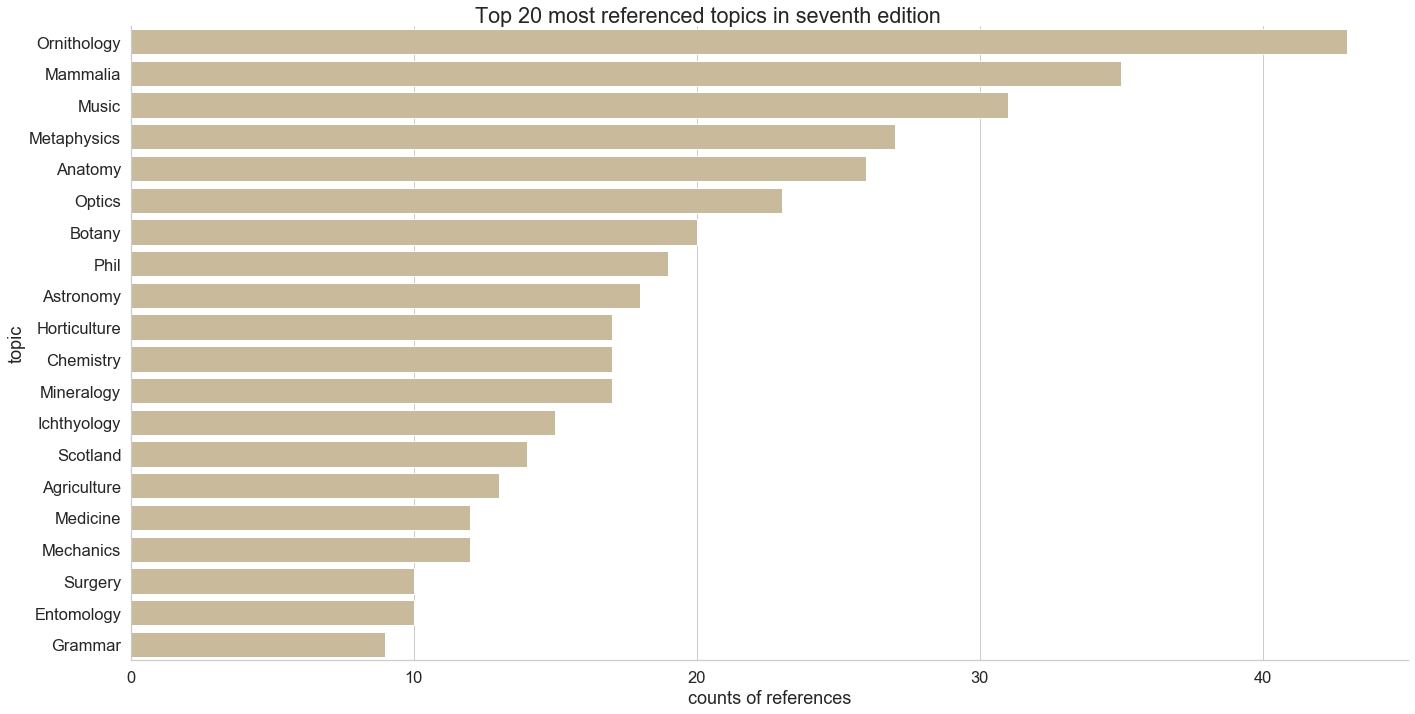

In [64]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
ax = sns.catplot(x='count', y='references', data=seventh_eighth_refs_counts[0].head(20), kind='bar', height=10, aspect=2, color="#cfbd93")
ax.fig.suptitle("Top 20 most referenced topics in seventh edition", y=1)
ax.set_axis_labels('counts of references', 'topic')

### Proportional topic popularity changes

In [140]:
def change_in_topic(topic, editions_ref_counts):
    
    counts = []
    for i in range(0, len(editions_ref_counts)):
        counts.append(int(editions_ref_counts[i].loc[editions_ref_counts[i].references == topic]['count']))
    return counts

In [141]:
change_in_topic("See Anatomy", two_edition_ref_counts)

[321, 178]

In [155]:
def show_change_in_topic(topic, editions_ref_counts):

    counts = change_in_topic(topic, editions_ref_counts)
    
    data = pd.DataFrame({"editions" : ["Edition 1", "Edition 2"],
                     "reference_count" : counts})

    plt.plot("editions", "reference_count", data=data)
    plt.show()

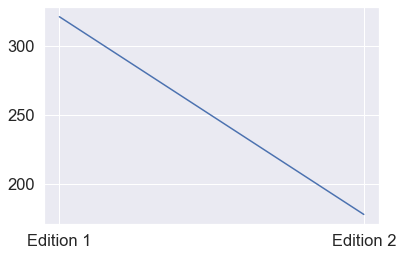

In [156]:
show_change_in_topic("See Anatomy", two_edition_ref_counts)

### Main topic analysis

In [169]:
len(two_data_cleaned[0].loc[two_data_cleaned[0].definition.str.contains("See Anatomy")])
# not same number, as other just checks ALL MENTIONS, not just in ref

262